In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).cuda()
model.eval()

Using cache found in /home/henistein/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

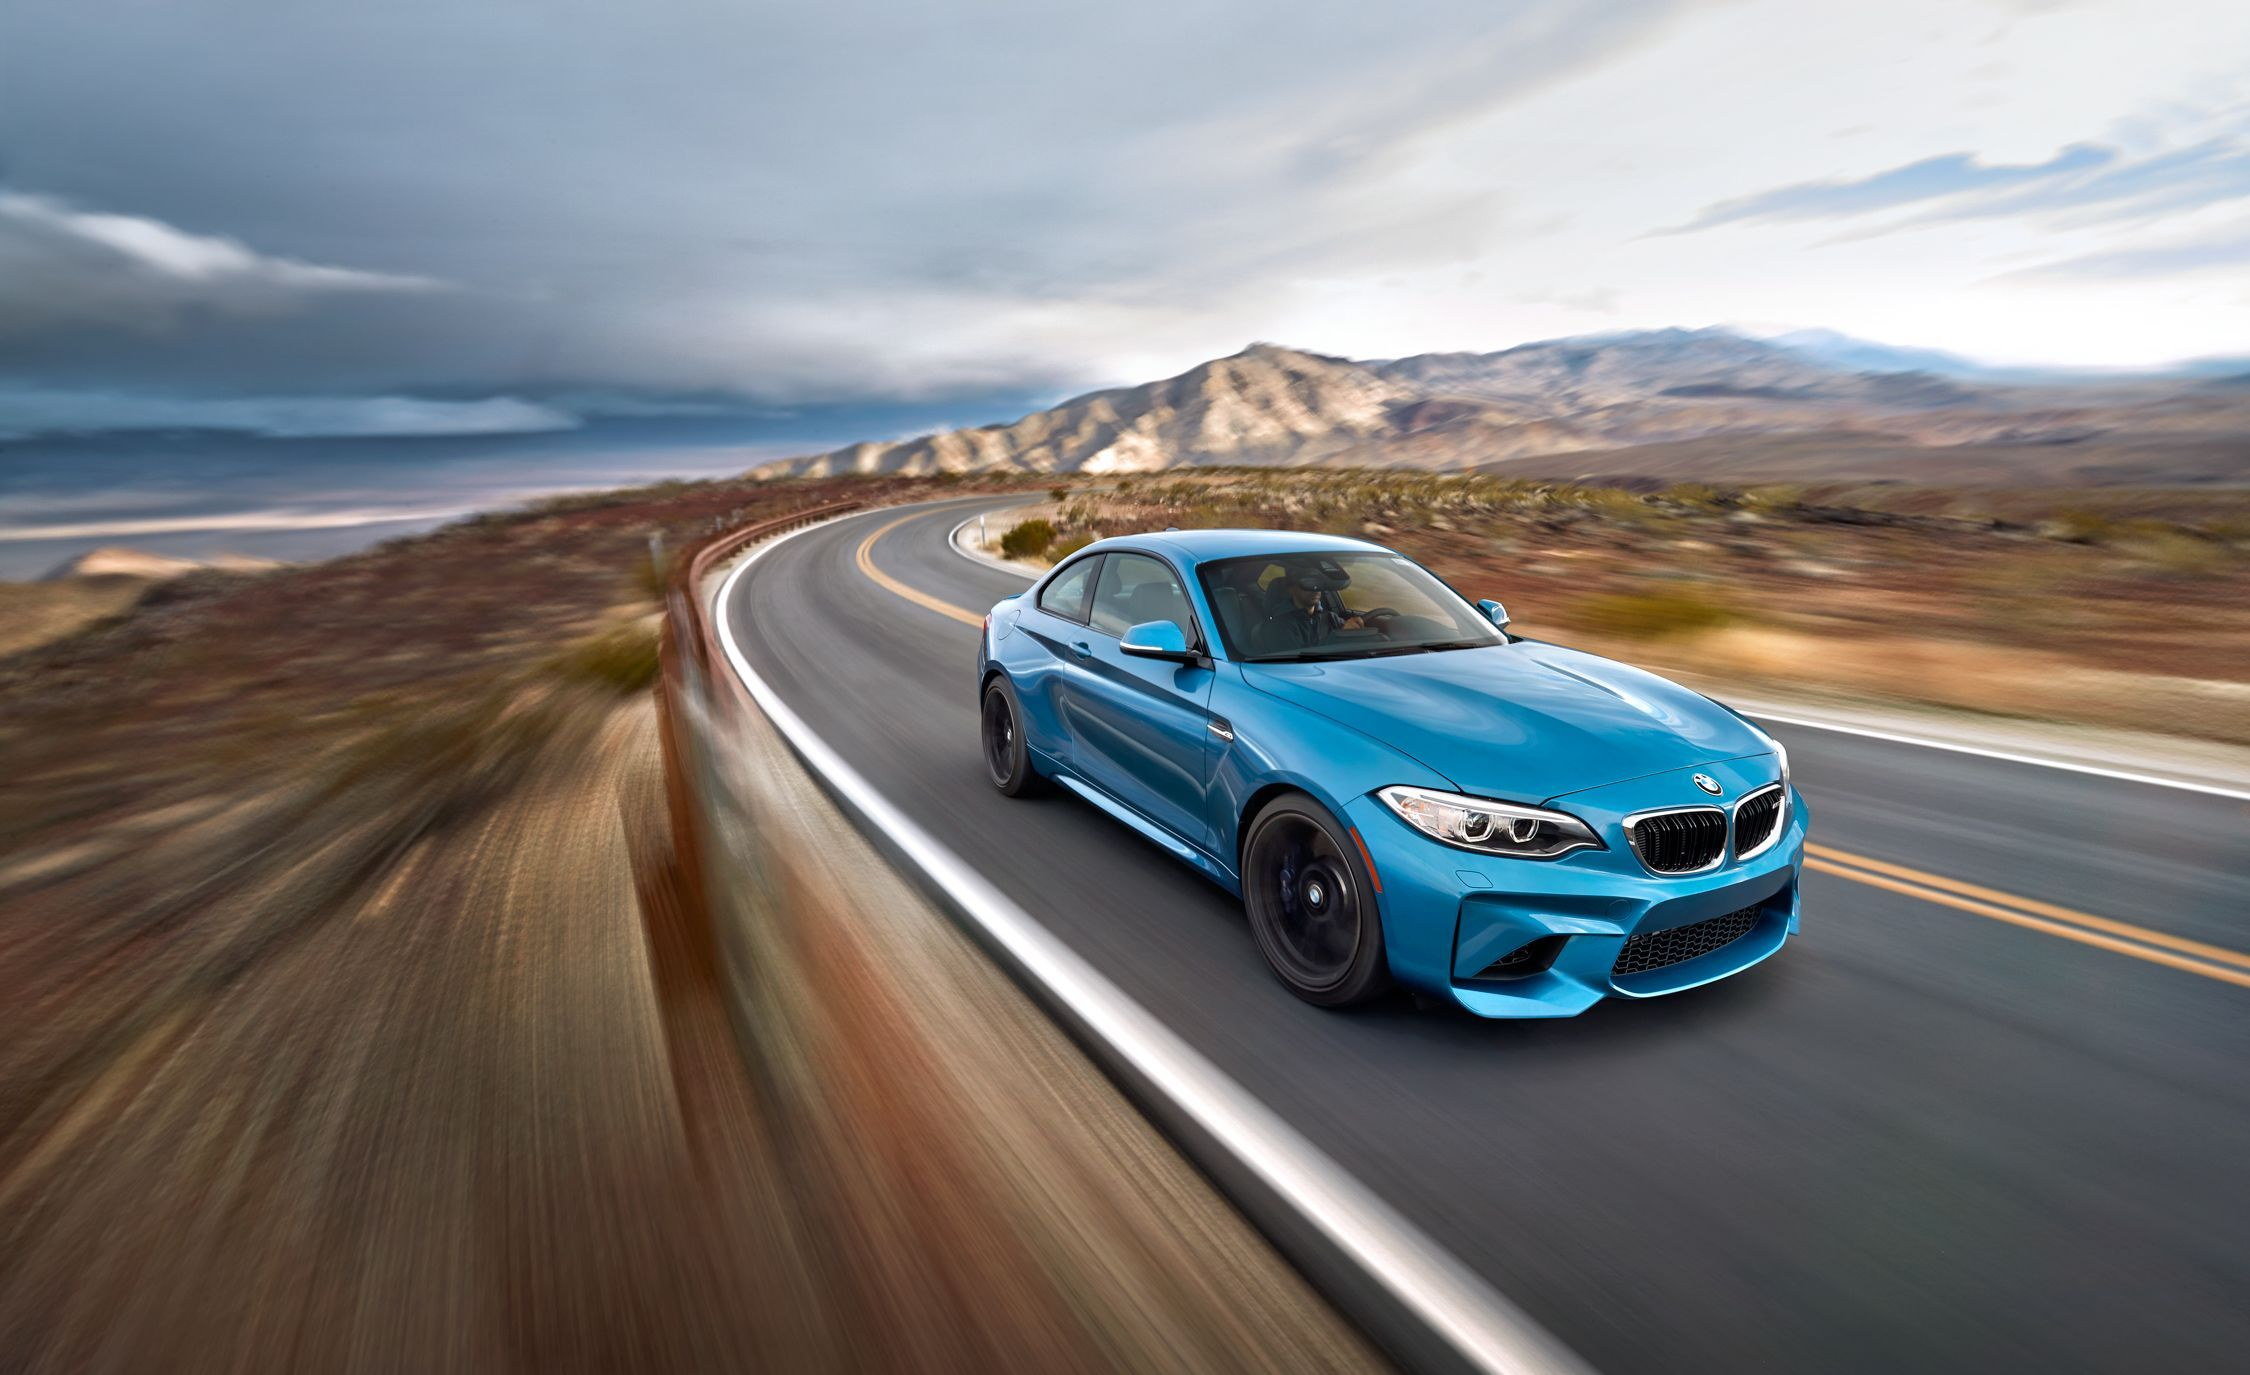

In [2]:
from PIL import Image
import requests
from io import BytesIO

#url = 'https://media-cdn.tripadvisor.com/media/photo-s/15/18/8b/2d/two-cars-admiring-the.jpg'
url = 'https://hips.hearstapps.com/hmg-prod/images/2016-bmw-m2-202-1585760824.jpg'
response = requests.get(url)
raw_img = Image.open(BytesIO(response.content))
raw_img

In [4]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
input_tensor = preprocess(raw_img)
input_batch = input_tensor.unsqueeze(0).cuda()

# inference
output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [5]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

sports car 0.5310030579566956
racer 0.40652889013290405
car wheel 0.025067923590540886
convertible 0.012206519953906536
beach wagon 0.0033741311635822058


## Integrated Gradients

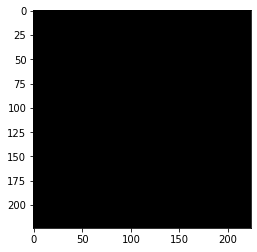

In [6]:
baseline = np.zeros((224, 224, 3))
plt.imshow(baseline)

### Interpolate Images

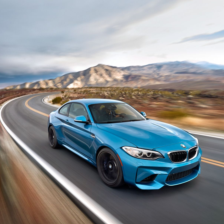

In [7]:
m_steps=50
alphas = np.linspace(0.0, 1.0, m_steps+1) # Generate m_steps intervals for integral_approximation() below.

# preprocess image
crop_size = 224
shift_amount = 0.6
img_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.Lambda(lambda img: img.crop((int(shift_amount * crop_size), 0, crop_size + int(shift_amount * crop_size), crop_size))),
])
img = img_preprocess(raw_img)
img

In [8]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]
  baseline_x = baseline[np.newaxis, :]
  input_x = image[np.newaxis, :]
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta
  return images

In [9]:
interpolated_imgs_ = interpolate_images(baseline, np.array(img), alphas)

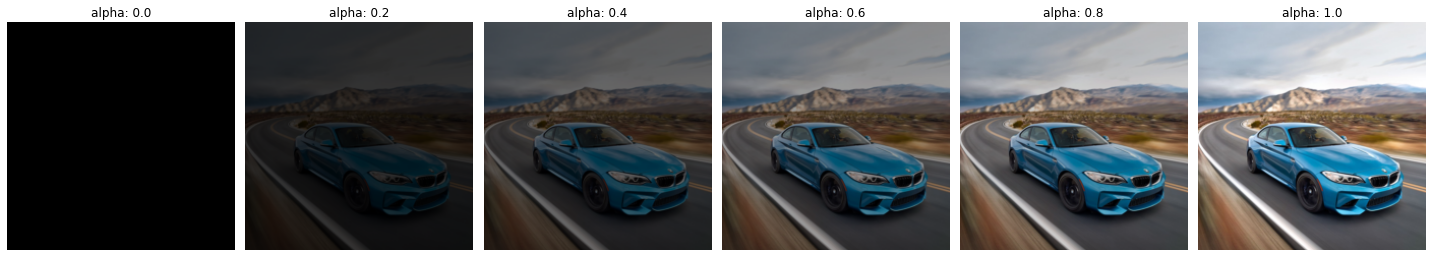

In [10]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_imgs_[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  image = image.astype(np.uint8)
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()

In [11]:
def compute_gradients(images, target_class_idx):
  if images.requires_grad is False: images.requires_grad = True
  logits = model(images)
  probs = torch.nn.functional.softmax(logits, dim=-1)[:, target_class_idx]
  grads = torch.autograd.grad(outputs=probs, inputs=images, grad_outputs=torch.ones_like(probs), retain_graph=True, create_graph=True)[0]
  return grads, probs

In [12]:
interpolated_imgs = torch.from_numpy(interpolated_imgs_).permute(0, 3, 1, 2)
interpolated_imgs = (interpolated_imgs.cuda() / 255).float()
path_gradients, probs = compute_gradients(images=interpolated_imgs[0::10], target_class_idx=817)

In [13]:
path_gradients.shape

torch.Size([6, 3, 224, 224])

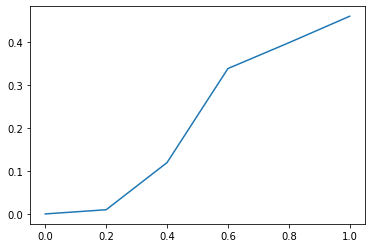

In [14]:
probs = probs.detach().cpu().numpy()
plt.plot(alphas[0::10], probs)

### Integral Approximation

In [15]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / torch.tensor(2.0)
  integrated_gradients = torch.mean(grads, dim=0)
  return integrated_gradients

In [22]:
ig = integral_approximation(gradients=path_gradients).permute(2, 1, 0)

In [23]:
ig.shape

torch.Size([224, 224, 3])

In [18]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    # Generate alphas.
    alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

    # Collect gradients.    
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in range(0, len(alphas), batch_size):
        from_ = alpha
        to = min(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Stack path gradients together row-wise into single tensor.
    total_gradients = torch.cat(gradient_batches, dim=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [28]:
integrated_gradients = (interpolated_imgs_[-1] - baseline) * ig.cpu().detach().numpy()

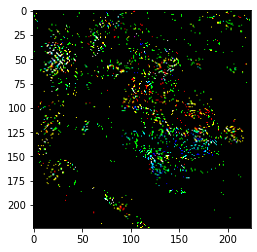

In [32]:
plt.imshow(np.uint8(integrated_gradients))